# Projet Apache Spark : Analyse des données climatiques mondiales

## Objectif :
Analyser les tendances climatiques mondiales à l'aide de Spark, y compris le nettoyage des données, l'EDA et l'extraction d'informations.

### Jeu de données :
[Global Surface Summary of the Day (GSOD) provenant de NOAA](https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.ncdc:C00516)


---
## Exploration du jeu de données


In [6]:
pip install aiohttp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.6 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.9/274.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.9/343.9 kB 9.2 MB/s eta 0:00:00:00:01
Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install aiofiles tqdm nest_asyncio certifi

Note: you may need to restart the kernel to use updated packages.


In [22]:
# Import 
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import udf
from pyspark.sql.window import Window
from pyspark.sql.types import TimestampType
from datetime import datetime
import os
import pandas as pd
import requests
from bs4 import BeautifulSoup
import asyncio
import aiohttp
import aiofiles
import os
from bs4 import BeautifulSoup
from tqdm.asyncio import tqdm
import nest_asyncio
import certifi
import ssl
import matplotlib.pyplot as plt
import gc

### Create Spark Session

In [38]:
# Create session 
# Création d'une session Spark
spark = SparkSession.builder \
    .appName("Analyse des logs des cyclistes") \
    .getOrCreate()

print("Session Spark créée avec succès !", spark) 

Session Spark créée avec succès ! <pyspark.sql.session.SparkSession object at 0x7f347c260a50>


### Affichage des données 

In [39]:
# Charger les données
data_path = "/home/jovyan/climate_analyses/data/sample.csv"

#### 1er tableau d'affichage

In [64]:
# Charger les données CSV dans un DataFrame
df = spark.read.csv(data_path, header=True, inferSchema=True)

# df = spark.read.csv('chemin/vers/dataset.csv', header=True, inferSchema=True)
# Afficher les 5 premières lignes pour vérifier
df.show(5)

+-----------+----------+--------+---------+---------+--------------------+----+---------------+----+---------------+------+--------------+-----+--------------+-----+----------------+----+---------------+-----+-----+----+--------------+----+--------------+----+---------------+-----+------+
|    STATION|      DATE|LATITUDE|LONGITUDE|ELEVATION|                NAME|TEMP|TEMP_ATTRIBUTES|DEWP|DEWP_ATTRIBUTES|   SLP|SLP_ATTRIBUTES|  STP|STP_ATTRIBUTES|VISIB|VISIB_ATTRIBUTES|WDSP|WDSP_ATTRIBUTES|MXSPD| GUST| MAX|MAX_ATTRIBUTES| MIN|MIN_ATTRIBUTES|PRCP|PRCP_ATTRIBUTES| SNDP|FRSHTT|
+-----------+----------+--------+---------+---------+--------------------+----+---------------+----+---------------+------+--------------+-----+--------------+-----+----------------+----+---------------+-----+-----+----+--------------+----+--------------+----+---------------+-----+------+
|72565003017|2018-01-01| 39.8328|-104.6575|   1650.2|DENVER INTERNATIO...|11.6|             24| 5.5|             24|1030.9|       

#### 2ème tableau d'affichage

In [41]:
# Récupérer la première ligne du DataFrame
first_row = df.first()

# Afficher les premières valeurs de chaque colonne horizontalement
print("Premières lignes de chaque colonne :")
for col_name in df.columns:
    print(f"{col_name}: {first_row[col_name]}")

Premières lignes de chaque colonne :
STATION: 72565003017
DATE: 2018-01-01
LATITUDE: 39.8328
LONGITUDE: -104.6575
ELEVATION: 1650.2
NAME: DENVER INTERNATIONAL AIRPORT, CO US
TEMP: 11.6
TEMP_ATTRIBUTES: 24
DEWP: 5.5
DEWP_ATTRIBUTES: 24
SLP: 1030.9
SLP_ATTRIBUTES: 24
STP: 839.1
STP_ATTRIBUTES: 24
VISIB: 7.1
VISIB_ATTRIBUTES: 24
WDSP: 5.0
WDSP_ATTRIBUTES: 24
MXSPD: 9.9
GUST: 999.9
MAX: 28.0
MAX_ATTRIBUTES:  
MIN: 3.0
MIN_ATTRIBUTES:  
PRCP: 0.0
PRCP_ATTRIBUTES: G
SNDP: 999.9
FRSHTT: 1000


#### Explication des Colonnes

##### Identifiants de la Station et Date
- **STATION** : L'identifiant unique de la station météorologique (souvent un code WMO ou NOAA).
- **DATE** : La date de l'enregistrement, au format AAAA-MMJJ.
#
#### Coordonnées Géographiques
- **LATITUDE** : Latitude de la station météorologique en degrés décimaux.
- **LONGITUDE** : Longitude de la station météorologique en degrés décimaux.
- **ELEVATION** : Altitude de la station en mètres au-dessus du niveau de la m#er.

#### Informations sur la Station
- **NAME** : Le nom de la station météorologique, généralement accompagné de sa localisation (ville, région ou #pays).

#### Température et Attributs
- **TEMP** : Température moyenne de l'air pour la journée, en degrés Celsius.
- **TEMP_ATTRIBUTES** : Indicateur qualitatif ou nombre d'observations utilisées pour calculer la températur#e moyenne.

#### Température du Point de Rosée
- **DEWP** : Température moyenne du point de rosée pour la journée, en degrés Celsius.
- **DEWP_ATTRIBUTES** : Indicateur qualitatif ou nombre d'observations utilisées pour calculer la température du p#oint de rosée.

#### Pression Atmosphérique
- **SLP (Sea Level Pressure)** : Pression moyenne au niveau de la mer, en hPa (hectopascals).
- **SLP_ATTRIBUTES** : Indicateur qualitatif ou nombre d'observations pour la pression au niveau de la mer.
- **STP (Station Pressure)** : Pression atmosphérique moyenne mesurée à la station, en hPa.
- **STP_ATTRIBUTES** : Indicateur qualitatif ou nombre d'observations pour la pr#ession à la station.

#### Visibilité
- **VISIB** : Visibilité moyenne de la journée, en kilomètres.
- **VISIB_ATTRIBUTES** : Indicateur qualitatif ou nombre d'observat#ions pour la visibilité.

#### Vent
- **WDSP (Wind Speed)** : Vitesse moyenne du vent sur la journée, en mètres par seconde.
- **WDSP_ATTRIBUTES** : Indicateur qualitatif ou nombre d'observations pour la vitesse du vent.
- **MXSPD (Max Speed)** : Vitesse maximale du vent enregistrée, en mètres par seconde.
- **GUST** : Rafales de vent maximales enregistrées, en mètres par seconde (si disponible). La valeur "999.9" peu#####diquer des données manquantes.

#### Températures Maximales et Minimales
- **MAX** : Température maximale enregistrée dans la journée, en degrés Celsius.
- **MAX_ATTRIBUTES** : Attributs ou indicateurs qualitatifs pour la température maximale.
- **MIN** : Température minimale enregistrée dans la journée, en degrés Celsius.
- **MIN_ATTRIBUTES** : Attributs ou indicateurs q#####tatifs pour la température minimale.

#### Précipitations et Neige
- **PRCP (Precipitation)** : Précipitations totales de la journée, en millimètres. La valeur "0.0" indique aucune précipitation.
- **PRCP_ATTRIBUTES** : Indicateur qualitatif pour les précipitations (par exemple, "G" peut signifier "estimé").
- **SNDP (Snow Depth)** : Profondeur de la neige en centimètres. La valeur #####.9" peut indiquer des données manquantes.

#### Conditions Météorologiques Spécifiques
- **FRSHTT** : Indicateur codé des événements météorologiques de la journée. Il est généralement représenté par une séquence de chiffres binaires indiquant :
  - **F** : Brouillard (Fog).
  - **R** : Pluie ou bruine (Rain/Drizzle).
  - **S** : Neige (Snow).
  - **H** : Grêle (Hail).
  - **T** : Orages (Thunderstorms).
  - **T** : Tornades ou vents violents (Tornado).

  Par exemple, **FRSHTT = iquement.

---

### Exemple Interprété
Pour votre ligne :


## **Questions 1 :**
1. Combien d'enregistrements contient le jeu de données 
2. Quels sont les noms et types de colonnes ?
3. Combien de stations météorologiques uniques sont présentes ?

## Réponse aux questions 1

### 1 - Nombre d'enregisitrements : 

In [46]:
# Calculer le nombre d'enregistrements dans le DataFrame
total_enregistrements = df.count()
print(f"Le jeu de données contient {total_enregistrements} enregistrements.")

Le jeu de données contient 365 enregistrements.


### 2 - Noms et types de colonnes : 

In [48]:
# Afficher les noms et types des colonnes
columns_and_types = df.dtypes
print("Noms et types des colonnes :")
for col_name, col_type in columns_and_types:
    print(f"- {col_name}: {col_type}")

# Calculer le nombre total de colonnes
total_columns = len(df.columns)
print(f"Le nombre total de colonnes dans le DataFrame est : {total_columns}")

Noms et types des colonnes :
- STATION: bigint
- DATE: date
- LATITUDE: double
- LONGITUDE: double
- ELEVATION: double
- NAME: string
- TEMP: double
- TEMP_ATTRIBUTES: int
- DEWP: double
- DEWP_ATTRIBUTES: int
- SLP: double
- SLP_ATTRIBUTES: int
- STP: double
- STP_ATTRIBUTES: int
- VISIB: double
- VISIB_ATTRIBUTES: int
- WDSP: double
- WDSP_ATTRIBUTES: int
- MXSPD: double
- GUST: double
- MAX: double
- MAX_ATTRIBUTES: string
- MIN: double
- MIN_ATTRIBUTES: string
- PRCP: double
- PRCP_ATTRIBUTES: string
- SNDP: double
- FRSHTT: int
Le nombre total de colonnes dans le DataFrame est : 28


### 3 - Nombres de stations métérologique uniques : 

In [56]:
# Récupérer les stations météorologiques uniques
unique_stations_df = df.select("STATION").distinct()

# Nombre de stations uniques
unique_stations_count = unique_stations_df.count()
print(f"Nombre de stations météorologiques uniques : {unique_stations_count}")

# Compter le nombre de lignes associées à chaque station unique
print("Nombre d'enregistrements pour chaque station :")
for station in unique_stations_df.collect():
    station_id = station['STATION']
    count = df.filter(df["STATION"] == station_id).count()
    print(f"Station : {station_id} - Nombre d'enregistrements : {count}")

Nombre de stations météorologiques uniques : 1
Nombre d'enregistrements pour chaque station :
Station : 72565003017 - Nombre d'enregistrements : 365


---
## Nettoyage des données


### Identifier les colonnes avec des valeurs manquantes et les traiter

#### Sql - Indentification et affichage des colonnes avec valeurs manquantes 

In [68]:
from pyspark.sql.functions import col, sum, when

# Calculer le nombre de valeurs nulles pour chaque colonne
null_counts = df.select(
    [sum(when(col(c).isNull() | col(c).contains("NaN"), 1).otherwise(0)).alias(c) for c in df.columns]
)

# Afficher le nombre de valeurs nulles par colonne
print("Nombre de valeurs nulles par colonne :")
null_counts.show(truncate=False)

# Trouver la colonne avec le plus de valeurs nulles
null_counts_pd = null_counts.toPandas().transpose()  # Convertir en Pandas pour une manipulation facile
null_counts_pd.columns = ["null_count"]
null_counts_pd = null_counts_pd.sort_values(by="null_count", ascending=False)

print("Colonne avec le plus de valeurs nulles :")
print(null_counts_pd)

Nombre de valeurs nulles par colonne :
+-------+----+--------+---------+---------+----+----+---------------+----+---------------+---+--------------+---+--------------+-----+----------------+----+---------------+-----+----+---+--------------+---+--------------+----+---------------+----+------+
|STATION|DATE|LATITUDE|LONGITUDE|ELEVATION|NAME|TEMP|TEMP_ATTRIBUTES|DEWP|DEWP_ATTRIBUTES|SLP|SLP_ATTRIBUTES|STP|STP_ATTRIBUTES|VISIB|VISIB_ATTRIBUTES|WDSP|WDSP_ATTRIBUTES|MXSPD|GUST|MAX|MAX_ATTRIBUTES|MIN|MIN_ATTRIBUTES|PRCP|PRCP_ATTRIBUTES|SNDP|FRSHTT|
+-------+----+--------+---------+---------+----+----+---------------+----+---------------+---+--------------+---+--------------+-----+----------------+----+---------------+-----+----+---+--------------+---+--------------+----+---------------+----+------+
|0      |0   |0       |0        |0        |0   |0   |0              |0   |0              |1  |0             |0  |0             |0    |0               |0   |0              |0    |110 |0  |0        

#### Traitement des valeurs manquantes 

In [70]:
# Traitement des valeurs manquantes
# 1. Supprimer les lignes avec des valeurs manquantes
df_cleaned = df.dropna(how="all")
df_cleaned = df_cleaned.dropna(subset=["SNDP", "GUST"])

# Colonnes numériques continues
numeric_columns = [
    "LATITUDE", "LONGITUDE", "ELEVATION", "TEMP", "DEWP", "SLP", "STP", 
    "VISIB", "WDSP", "MXSPD", "MAX", "MIN", "PRCP"
]

# Colonnes numériques discrètes
integer_columns = [
    "TEMP_ATTRIBUTES", "DEWP_ATTRIBUTES", "SLP_ATTRIBUTES", "STP_ATTRIBUTES", 
    "VISIB_ATTRIBUTES", "WDSP_ATTRIBUTES", "FRSHTT"
]

# Colonnes catégoriques
categorical_columns = ["MAX_ATTRIBUTES", "MIN_ATTRIBUTES", "PRCP_ATTRIBUTES", "NAME"]

# Remplacer les valeurs spéciales comme 999.9 par null
for col_name in numeric_columns:
    df_cleaned = df_cleaned.withColumn(col_name, when(col(col_name) == 999.9, None).otherwise(col(col_name)))

# Caster les colonnes numériques continues en double
for col_name in numeric_columns:
    df_cleaned = df_cleaned.withColumn(col_name, col(col_name).cast("double"))

# Caster les colonnes numériques discrètes en entier
for col_name in integer_columns:
    df_cleaned = df_cleaned.withColumn(col_name, col(col_name).cast("int"))

# Caster les colonnes catégoriques en string
for col_name in categorical_columns:
    df_cleaned = df_cleaned.withColumn(col_name, col(col_name).cast("string"))

# Vérifier les conversions
print("Colonnes après conversion et nettoyage :")
df_cleaned.printSchema()

# Afficher un aperçu des données nettoyées
print("Aperçu des données après conversion et remplacement des valeurs spéciales :")
df_cleaned.show(5, truncate=False)

Colonnes après conversion et nettoyage :
root
 |-- STATION: long (nullable = true)
 |-- DATE: date (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- ELEVATION: double (nullable = true)
 |-- NAME: string (nullable = true)
 |-- TEMP: double (nullable = true)
 |-- TEMP_ATTRIBUTES: integer (nullable = true)
 |-- DEWP: double (nullable = true)
 |-- DEWP_ATTRIBUTES: integer (nullable = true)
 |-- SLP: double (nullable = true)
 |-- SLP_ATTRIBUTES: integer (nullable = true)
 |-- STP: double (nullable = true)
 |-- STP_ATTRIBUTES: integer (nullable = true)
 |-- VISIB: double (nullable = true)
 |-- VISIB_ATTRIBUTES: integer (nullable = true)
 |-- WDSP: double (nullable = true)
 |-- WDSP_ATTRIBUTES: integer (nullable = true)
 |-- MXSPD: double (nullable = true)
 |-- GUST: double (nullable = true)
 |-- MAX: double (nullable = true)
 |-- MAX_ATTRIBUTES: string (nullable = true)
 |-- MIN: double (nullable = true)
 |-- MIN_ATTRIBUTES: string (nulla

#### Affichage des résultats

In [71]:
# Afficher le résultat des DataFrames traités
print("DataFrame après suppression des lignes avec des valeurs manquantes :")
print(f"Nombre de lignes après suppression : {df_cleaned.count()}")
df_cleaned.show(5, truncate=False)

print("DataFrame après remplissage des valeurs manquantes :")
print(f"Nombre de lignes après remplissage : {df_filled.count()}")
df_filled.show(5, truncate=False)

DataFrame après suppression des lignes avec des valeurs manquantes :
Nombre de lignes après suppression : 7
+-----------+----------+--------+---------+---------+-----------------------------------+----+---------------+----+---------------+------+--------------+-----+--------------+-----+----------------+----+---------------+-----+----+----+--------------+----+--------------+----+---------------+----+------+
|STATION    |DATE      |LATITUDE|LONGITUDE|ELEVATION|NAME                               |TEMP|TEMP_ATTRIBUTES|DEWP|DEWP_ATTRIBUTES|SLP   |SLP_ATTRIBUTES|STP  |STP_ATTRIBUTES|VISIB|VISIB_ATTRIBUTES|WDSP|WDSP_ATTRIBUTES|MXSPD|GUST|MAX |MAX_ATTRIBUTES|MIN |MIN_ATTRIBUTES|PRCP|PRCP_ATTRIBUTES|SNDP|FRSHTT|
+-----------+----------+--------+---------+---------+-----------------------------------+----+---------------+----+---------------+------+--------------+-----+--------------+-----+----------------+----+---------------+-----+----+----+--------------+----+--------------+----+------------

## **Questions 2 :**
1. Quelles colonnes ont le plus de valeurs manquantes ?
2. Après nettoyage, combien d'enregistrements restent ?
3. Quelle technique avez-vous utilisée pour traiter les valeurs manquantes dans la colonne des précipitations ?

## Réponse aux questions 2

### 1 - Colonnes avec le plus de valeurs manquantes : 

In [74]:
# Calculer le nombre de valeurs nulles pour chaque colonne
null_counts = df.select(
    [sum(when(col(c).isNull() | col(c).contains("NaN"), 1).otherwise(0)).alias(c) for c in df.columns]
)

# Trouver la colonne avec le plus de valeurs nulles
null_counts_transposed = null_counts.collect()[0].asDict()  # Convertir en dictionnaire
max_null_column = max(null_counts_transposed, key=null_counts_transposed.get)  # Trouver la clé avec la valeur maximale

print(f"Colonne avec le plus de valeurs nulles : {max_null_column} ({null_counts_transposed[max_null_column]} valeurs nulles)")

Colonne avec le plus de valeurs nulles : SNDP (347 valeurs nulles)


### 2 - Nombres d"enregistrement apres nettoyage : 

In [79]:
# Afficher le résultat après suppression des lignes avec des valeurs manquantes
print("DataFrame après suppression des lignes avec des valeurs manquantes :")
total_after_dropna = df_cleaned.count()
print(f"Nombre total d'enregistrements après suppression : {total_after_dropna}")

# Afficher le résultat après remplissage des valeurs manquantes
print("\nDataFrame après remplissage des valeurs manquantes :")
total_after_fillna = df_filled.count()
print(f"Nombre total d'enregistrements après remplissage : {total_after_fillna}")

DataFrame après suppression des lignes avec des valeurs manquantes :
Nombre total d'enregistrements après suppression : 7

DataFrame après remplissage des valeurs manquantes :
Nombre total d'enregistrements après remplissage : 365


### 3 - Technique utilisés pour traiter les valeurs manquantes : 

#### Traitement des valeurs manquantes dans la colonne PRCP (précipitations)

Pour traiter les valeurs manquantes dans la colonne **PRCP (précipitations)**, nous avons utilisé ces étapes :

1. **Remplacement des valeurs spéciales (999.9)** : 
   - Les valeurs `999.9` ont été remplacées par `null` pour identifier les données manquantes.

2. **Imputation par la moyenne** :
   - Les valeurs manquantes ont été remplacées par la moyenne des précipitations non nulles.

3. **Ajout d’un indicateur (`PRCP_missing`)** :
   - Une colonne binaire a été ajoutée pour signaler si une valeur était initialement manquante (`1`) ou non (`0`).


---
## Transformation des données


In [81]:
# Transformer le jeu de données
# Ajouter de nouvelles colonnes pour l'année, le mois, le jour
#df_transformed = df_cleaned.withColumn('year', F.year(F.col('date')))
# Classifier les jours chauds
#df_transformed = df_transformed.withColumn('is_hot', F.col('temperature') > 30)

## **Questions 3 :**
1. Quels sont les 5 premiers enregistrements après le parsing de la colonne `date` ?
2. Combien de jours ont été classés comme 'chauds' ?
3. Quelles transformations ont été appliquées au jeu de données ?

## Réponse aux questions 3

### 1 - 5 premiers enregistrements apres parsing de date : 

In [82]:
from pyspark.sql.functions import col, to_date, mean

##### 1. Parsing de la colonne `date` en type Date
df = df.withColumn("DATE", to_date(col("DATE"), "yyyy-MM-dd"))

##### Afficher les 5 premiers enregistrements après parsing de la colonne DATE
print("1. Les 5 premiers enregistrements après parsing de la colonne `DATE` :")
df.show(5, truncate=False)


1. Les 5 premiers enregistrements après parsing de la colonne `DATE` :
+-----------+----------+--------+---------+---------+-----------------------------------+----+---------------+----+---------------+------+--------------+-----+--------------+-----+----------------+----+---------------+-----+----+----+--------------+----+--------------+----+---------------+----+------+
|STATION    |DATE      |LATITUDE|LONGITUDE|ELEVATION|NAME                               |TEMP|TEMP_ATTRIBUTES|DEWP|DEWP_ATTRIBUTES|SLP   |SLP_ATTRIBUTES|STP  |STP_ATTRIBUTES|VISIB|VISIB_ATTRIBUTES|WDSP|WDSP_ATTRIBUTES|MXSPD|GUST|MAX |MAX_ATTRIBUTES|MIN |MIN_ATTRIBUTES|PRCP|PRCP_ATTRIBUTES|SNDP|FRSHTT|
+-----------+----------+--------+---------+---------+-----------------------------------+----+---------------+----+---------------+------+--------------+-----+--------------+-----+----------------+----+---------------+-----+----+----+--------------+----+--------------+----+---------------+----+------+
|72565003017|2018-01

### 2 - Nombres de jours classés comme chaud : 

In [84]:
# 2. Définir les jours "chauds" comme ceux où la température maximale (MAX) est supérieure à un seuil (exemple : 30°C)
hot_days = df.filter(col("MAX") > 30).count()
print(f"2. Nombre de jours classés comme 'chauds' : {hot_days}")

2. Nombre de jours classés comme 'chauds' : 359


### 3 - Transformation appliqués au jeu de données : 

In [86]:
print("3. Transformations appliquées au jeu de données :")
transformations = """
1. Parsing de la colonne `DATE` pour la convertir en format DateTime.
2. Remplacement des valeurs spéciales (ex : 999.9) par `null` pour les colonnes numériques.
3. Imputation des valeurs manquantes (ex : moyenne pour `PRCP`).
4. Ajout d'une colonne binaire `PRCP_missing` pour signaler les valeurs imputées.
5. Conversion des types de colonnes (ex : cast des colonnes numériques en `double` et des colonnes discrètes en `int`).
"""
print(transformations)

3. Transformations appliquées au jeu de données :

1. Parsing de la colonne `DATE` pour la convertir en format DateTime.
2. Remplacement des valeurs spéciales (ex : 999.9) par `null` pour les colonnes numériques.
3. Imputation des valeurs manquantes (ex : moyenne pour `PRCP`).
4. Ajout d'une colonne binaire `PRCP_missing` pour signaler les valeurs imputées.
5. Conversion des types de colonnes (ex : cast des colonnes numériques en `double` et des colonnes discrètes en `int`).



---
##  Analyse exploratoire des données (EDA)


In [ ]:
# Calculer les moyennes annuelles et autres statistiques
# avg_temp_by_year = df_transformed.groupBy('year').avg('temperature')
# avg_temp_by_year.show()

## **Questions 4 :**
1. Quelle est la température moyenne mondiale pour 2020 ?
2. Quelles sont les 5 stations ayant enregistré les températures moyennes les plus élevées, et où sont-elles situées ?
3. Comment les précipitations mondiales ont-elles changé au cours des 50 dernières années ?

## Réponse aux questions 4

### Téléchargement des fichiers par date

In [9]:
# Appliquer nest_asyncio pour permettre l'exécution dans une boucle d'événements existante
try:
    nest_asyncio.apply()
except RuntimeError:
    pass  # La boucle d'événements est déjà appliquée

# Créer un contexte SSL utilisant certifi
ssl_context = ssl.create_default_context(cafile=certifi.where())

async def fetch_file_urls(session, base_url, year):
    """
    Récupère les URLs des fichiers CSV pour une année donnée depuis le site NOAA.
    """
    year_url = f"{base_url}{year}/"
    try:
        async with session.get(year_url, ssl=ssl_context) as response:
            if response.status != 200:
                print(f"Erreur lors de l'accès à {year_url}, statut {response.status}")
                return []
            content = await response.text()
    except Exception as e:
        print(f"Erreur lors de la récupération de {year_url} : {e}")
        return []

    soup = BeautifulSoup(content, "html.parser")
    files = [year_url + link.get("href") for link in soup.find_all("a") if link.get("href").endswith(".csv")]
    return files

async def download_file(session, url, download_folder, semaphore):
    """
    Télécharge un fichier CSV et le sauvegarde dans le dossier approprié.
    """
    async with semaphore:
        file_name = url.split("/")[-1]
        date_part = url.split("/")[-2]
        date_folder = os.path.join(download_folder, date_part)
        os.makedirs(date_folder, exist_ok=True)
        file_path = os.path.join(date_folder, file_name)

        # Vérifier si le fichier existe déjà
        if os.path.exists(file_path):
            print(f"Fichier déjà présent : {file_path}")
            return True  # Considérer comme téléchargé

        # Télécharger le fichier s'il n'existe pas
        try:
            async with session.get(url, ssl=ssl_context) as response:
                if response.status != 200:
                    print(f"Échec du téléchargement de {url}, statut {response.status}")
                    return False
                content = await response.read()
            async with aiofiles.open(file_path, 'wb') as f:
                await f.write(content)
            return True
        except Exception as e:
            print(f"Erreur lors du téléchargement de {url}: {e}")
            return False

async def download_all_files(file_urls, download_folder="data", max_concurrent=200):
    """
    Télécharge tous les fichiers CSV de manière asynchrone avec une limite de concurrence.
    """
    os.makedirs(download_folder, exist_ok=True)
    semaphore = asyncio.Semaphore(max_concurrent)
    async with aiohttp.ClientSession() as session:
        tasks = [
            download_file(session, url, download_folder, semaphore)
            for url in file_urls
        ]
        results = []
        for f in tqdm(asyncio.as_completed(tasks), total=len(tasks), desc="Téléchargement des fichiers"):
            result = await f
            results.append(result)
    return results

async def get_all_file_urls(base_url, years):
    """
    Récupère toutes les URLs des fichiers CSV pour une liste d'années.
    """
    file_urls = []
    async with aiohttp.ClientSession() as session:
        for year in tqdm(years, desc="Récupération des URLs par année"):
            urls = await fetch_file_urls(session, base_url, year)
            file_urls.extend(urls)
    return file_urls

async def main():
    base_url = "https://www.ncei.noaa.gov/data/global-summary-of-the-day/access/"
    years = list(range(1929, 2025))  # Années de 1929 à 2024
    download_folder = "data"

    # Vérification préalable des fichiers existants
    existing_folders = {str(year): os.path.exists(os.path.join(download_folder, str(year))) for year in years}

    # Filtrer les années pour lesquelles les dossiers n'existent pas
    years_to_download = [year for year in years if not existing_folders[str(year)]]

    if not years_to_download:
        print("Tous les dossiers pour les années spécifiées existent déjà.")
        return

    # Récupérer toutes les URLs des fichiers pour les années manquantes
    file_urls = await get_all_file_urls(base_url, years_to_download)

    if not file_urls:
        print("Aucun fichier CSV trouvé pour les années spécifiées.")
        return

    print(f"Nombre total de fichiers à télécharger : {len(file_urls)}")

    # Télécharger tous les fichiers de manière asynchrone
    downloaded_files = await download_all_files(file_urls, download_folder=download_folder, max_concurrent=100)

    # Corriger le comptage des succès
    success = downloaded_files.count(True)
    total = len(downloaded_files)
    print(f"Téléchargement terminé : {success}/{total} fichiers téléchargés avec succès.")

# Exécution du script
if __name__ == "__main__":
    asyncio.run(main())


Récupération des URLs par année: 100%|██████████| 96/96 [06:22<00:00,  3.99s/it]


Nombre total de fichiers à télécharger : 582776


Téléchargement des fichiers:  90%|█████████ | 524808/582776 [1:21:59<21:03, 45.87it/s]  

Erreur lors du téléchargement de https://www.ncei.noaa.gov/data/global-summary-of-the-day/access/1996/74230024037.csv: Response payload is not completed: <ContentLengthError: 400, message='Not enough data for satisfy content length header.'>
Erreur lors du téléchargement de https://www.ncei.noaa.gov/data/global-summary-of-the-day/access/1957/99999913973.csv: Response payload is not completed: <ContentLengthError: 400, message='Not enough data for satisfy content length header.'>
Erreur lors du téléchargement de https://www.ncei.noaa.gov/data/global-summary-of-the-day/access/2024/95718099999.csv: Response payload is not completed: <ContentLengthError: 400, message='Not enough data for satisfy content length header.'>


Téléchargement des fichiers:  90%|█████████ | 525387/582776 [1:22:14<21:49, 43.83it/s]

Erreur lors du téléchargement de https://www.ncei.noaa.gov/data/global-summary-of-the-day/access/2000/72646699999.csv: Response payload is not completed: <ContentLengthError: 400, message='Not enough data for satisfy content length header.'>
Erreur lors du téléchargement de https://www.ncei.noaa.gov/data/global-summary-of-the-day/access/2024/24261099999.csv: Response payload is not completed: <ContentLengthError: 400, message='Not enough data for satisfy content length header.'>


Téléchargement des fichiers:  90%|█████████ | 526404/582776 [1:22:43<20:27, 45.92it/s]  

Erreur lors du téléchargement de https://www.ncei.noaa.gov/data/global-summary-of-the-day/access/2000/72646599999.csv: Response payload is not completed: <ContentLengthError: 400, message='Not enough data for satisfy content length header.'>


Téléchargement des fichiers:  90%|█████████ | 526410/582776 [1:22:44<27:12, 34.54it/s]

Erreur lors du téléchargement de https://www.ncei.noaa.gov/data/global-summary-of-the-day/access/1975/25568099999.csv: Response payload is not completed: <ContentLengthError: 400, message='Not enough data for satisfy content length header.'>
Erreur lors du téléchargement de https://www.ncei.noaa.gov/data/global-summary-of-the-day/access/1979/47581099999.csv: Response payload is not completed: <ContentLengthError: 400, message='Not enough data for satisfy content length header.'>
Erreur lors du téléchargement de https://www.ncei.noaa.gov/data/global-summary-of-the-day/access/1996/74207024201.csv: Response payload is not completed: <ContentLengthError: 400, message='Not enough data for satisfy content length header.'>


Téléchargement des fichiers:  93%|█████████▎| 543125/582776 [1:29:42<07:18, 90.37it/s]  

Erreur lors du téléchargement de https://www.ncei.noaa.gov/data/global-summary-of-the-day/access/1985/40416099999.csv: Response payload is not completed: <ContentLengthError: 400, message='Not enough data for satisfy content length header.'>
Erreur lors du téléchargement de https://www.ncei.noaa.gov/data/global-summary-of-the-day/access/2005/15480099999.csv: Response payload is not completed: <ContentLengthError: 400, message='Not enough data for satisfy content length header.'>


Téléchargement des fichiers:  94%|█████████▎| 546024/582776 [1:30:26<08:06, 75.50it/s]

Erreur lors du téléchargement de https://www.ncei.noaa.gov/data/global-summary-of-the-day/access/2005/15530099999.csv: Response payload is not completed: <ContentLengthError: 400, message='Not enough data for satisfy content length header.'>
Erreur lors du téléchargement de https://www.ncei.noaa.gov/data/global-summary-of-the-day/access/2020/99999903033.csv: Response payload is not completed: <ContentLengthError: 400, message='Not enough data for satisfy content length header.'>
Erreur lors du téléchargement de https://www.ncei.noaa.gov/data/global-summary-of-the-day/access/2024/99400799999.csv: Response payload is not completed: <ContentLengthError: 400, message='Not enough data for satisfy content length header.'>
Erreur lors du téléchargement de https://www.ncei.noaa.gov/data/global-summary-of-the-day/access/1979/47759099999.csv: Response payload is not completed: <ContentLengthError: 400, message='Not enough data for satisfy content length header.'>
Erreur lors du téléchargement de

Téléchargement des fichiers:  94%|█████████▎| 546043/582776 [1:30:27<08:51, 69.11it/s]

Erreur lors du téléchargement de https://www.ncei.noaa.gov/data/global-summary-of-the-day/access/1964/40582099999.csv: Response payload is not completed: <ContentLengthError: 400, message='Not enough data for satisfy content length header.'>
Erreur lors du téléchargement de https://www.ncei.noaa.gov/data/global-summary-of-the-day/access/1965/62336099999.csv: Response payload is not completed: <ContentLengthError: 400, message='Not enough data for satisfy content length header.'>
Erreur lors du téléchargement de https://www.ncei.noaa.gov/data/global-summary-of-the-day/access/2018/41140099999.csv: Response payload is not completed: <ContentLengthError: 400, message='Not enough data for satisfy content length header.'>
Erreur lors du téléchargement de https://www.ncei.noaa.gov/data/global-summary-of-the-day/access/2005/15533099999.csv: Response payload is not completed: <ContentLengthError: 400, message='Not enough data for satisfy content length header.'>
Erreur lors du téléchargement de

Téléchargement des fichiers:  94%|█████████▎| 546066/582776 [1:30:27<07:09, 85.40it/s]

Erreur lors du téléchargement de https://www.ncei.noaa.gov/data/global-summary-of-the-day/access/2024/27106099999.csv: Response payload is not completed: <ContentLengthError: 400, message='Not enough data for satisfy content length header.'>
Erreur lors du téléchargement de https://www.ncei.noaa.gov/data/global-summary-of-the-day/access/2023/71084099999.csv: Response payload is not completed: <ContentLengthError: 400, message='Not enough data for satisfy content length header.'>
Erreur lors du téléchargement de https://www.ncei.noaa.gov/data/global-summary-of-the-day/access/1965/62338099999.csv: Response payload is not completed: <ContentLengthError: 400, message='Not enough data for satisfy content length header.'>
Erreur lors du téléchargement de https://www.ncei.noaa.gov/data/global-summary-of-the-day/access/2005/15535099999.csv: Response payload is not completed: <ContentLengthError: 400, message='Not enough data for satisfy content length header.'>
Erreur lors du téléchargement de

Téléchargement des fichiers: 100%|██████████| 582776/582776 [1:39:26<00:00, 97.68it/s] 


Téléchargement terminé : 582747/582776 fichiers téléchargés avec succès.


### 1- la température moyenne mondiale pour 2020

In [10]:
def calculate_avg_temp_from_absolute_path(absolute_path):
    """
    Calcule la température moyenne mondiale pour les fichiers CSV dans un chemin absolu donné.
    """
    all_data_frames = []

    # Vérifier si le chemin absolu existe et charger les fichiers CSV
    try:
        files = [file for file in os.listdir(absolute_path) if file.endswith(".csv")]
        total_files = len(files)

        if total_files == 0:
            print(f"Aucun fichier CSV trouvé dans le chemin {absolute_path}.")
            return None

        for file in tqdm(files, desc="Chargement des fichiers", unit="fichier"):
            file_path = f"{absolute_path}/{file}"  # Construire le chemin complet
            try:
                df = pd.read_csv(file_path)
                all_data_frames.append(df)
            except Exception as e:
                print(f"Erreur lors du chargement de {file_path}: {e}")
    except FileNotFoundError:
        print(f"Le chemin {absolute_path} n'existe pas.")
        return None

    # Concaténer tous les fichiers dans un seul DataFrame
    if all_data_frames:
        full_data = pd.concat(all_data_frames, ignore_index=True)
        # Calculer la moyenne de la colonne 'TEMP'
        if 'TEMP' in full_data.columns:
            avg_temp = full_data['TEMP'].mean()
            return avg_temp
        else:
            print("La colonne 'TEMP' est absente des données.")
            return None
    else:
        print(f"Aucun fichier CSV trouvé dans le chemin {absolute_path}.")
        return None

# Calculer la température moyenne pour 2020 en utilisant un chemin absolu
absolute_path_2020 = "/home/jovyan/climate_analyses/data/2020"
average_temp_2020 = calculate_avg_temp_from_absolute_path(absolute_path_2020)

if average_temp_2020 is not None:
    print(f"Température moyenne mondiale pour 2020 : {average_temp_2020:.2f}°C")
else:
    print(f"Impossible de calculer la température moyenne pour 2020.")

Chargement des fichiers: 100%|██████████| 12298/12298 [00:47<00:00, 256.99fichier/s]


Température moyenne mondiale pour 2020 : 55.55°C


### 2 - les 5 stations ayant enregistré les températures moyennes les plus élevées, et où sont-elles situées 

In [11]:
def top_5_hottest_stations(absolute_path):
    """
    Trouve les 5 stations ayant enregistré les températures moyennes les plus élevées.
    """
    all_data_frames = []

    # Vérifier si le chemin absolu existe et charger les fichiers CSV
    try:
        files = [file for file in os.listdir(absolute_path) if file.endswith(".csv")]
        if not files:
            print(f"Aucun fichier CSV trouvé dans le chemin {absolute_path}.")
            return None

        for file in tqdm(files, desc="Chargement des fichiers", unit="fichier"):
            file_path = f"{absolute_path}/{file}"  # Construire le chemin complet
            try:
                df = pd.read_csv(file_path)
                all_data_frames.append(df)
            except Exception as e:
                print(f"Erreur lors du chargement de {file_path}: {e}")
    except FileNotFoundError:
        print(f"Le chemin {absolute_path} n'existe pas.")
        return None

    # Concaténer tous les fichiers dans un seul DataFrame
    if all_data_frames:
        full_data = pd.concat(all_data_frames, ignore_index=True)

        # Vérifier si les colonnes nécessaires existent
        if 'TEMP' in full_data.columns and 'STATION' in full_data.columns and 'NAME' in full_data.columns:
            # Calculer la température moyenne par station
            grouped_data = (
                full_data.groupby(['STATION', 'NAME'])['TEMP']
                .mean()
                .reset_index()
                .sort_values(by='TEMP', ascending=False)
                .head(5)  # Garder les 5 stations les plus chaudes
            )
            return grouped_data
        else:
            print("Les colonnes nécessaires ('TEMP', 'STATION', 'NAME') sont absentes des données.")
            return None
    else:
        print(f"Aucun fichier CSV trouvé dans le chemin {absolute_path}.")
        return None

# Appeler la fonction pour trouver les 5 stations les plus chaudes
top_stations_2020 = top_5_hottest_stations(absolute_path_2020)

if top_stations_2020 is not None:
    print("\nLes 5 stations ayant enregistré les températures moyennes les plus élevées :")
    print(top_stations_2020)
else:
    print("Impossible de déterminer les 5 stations les plus chaudes.")


Chargement des fichiers: 100%|██████████| 12298/12298 [00:33<00:00, 366.42fichier/s]



Les 5 stations ayant enregistré les températures moyennes les plus élevées :
          STATION           NAME        TEMP
4255  41250099999   SUNAYNAH, MU  103.071429
4262  41262099999  FAHUD AUT, MU  101.528571
4282  41304099999     MARMUL, MU  100.042857
4254  41249099999    QUMAIRA, MU   98.642857
4261  41257099999     SAMAIL, MU   98.471429


### 3. les précipitations mondiales ont-elles changé au cours des 50 dernières années

Traitement par année: 100%|██████████| 51/51 [38:13<00:00, 44.96s/it]


Sauvegarde des résultats dans le fichier cache : precipitation_cache.csv

Précipitations moyennes annuelles (1974-2024) :
    YEAR   AVG_PRCP
0   1974   9.435643
1   1975  10.260407
2   1976   8.947381
3   1977   7.854758
4   1978   7.863450
5   1979   6.082201
6   1980   5.614162
7   1981   5.725428
8   1982   4.709797
9   1983   4.231729
10  1984   4.187880
11  1985   4.357146
12  1986   4.552233
13  1987   4.485590
14  1988   4.402140
15  1989   5.036714
16  1990   5.763479
17  1991   5.693645
18  1992   5.787002
19  1993   5.235889
20  1994   4.866025
21  1995   3.775562
22  1996   4.382370
23  1997   2.206427
24  1998   2.486183
25  1999  10.530504
26  2000   8.851444
27  2001   8.777935
28  2002   7.691012
29  2003   6.058540
30  2004   6.030815
31  2005   8.402943
32  2006   9.393119
33  2007   9.471414
34  2008   9.547894
35  2009   9.754092
36  2010   9.715870
37  2011   9.849283
38  2012   9.184002
39  2013   8.492927
40  2014   8.217005
41  2015   7.564388
42  2016   7.62204

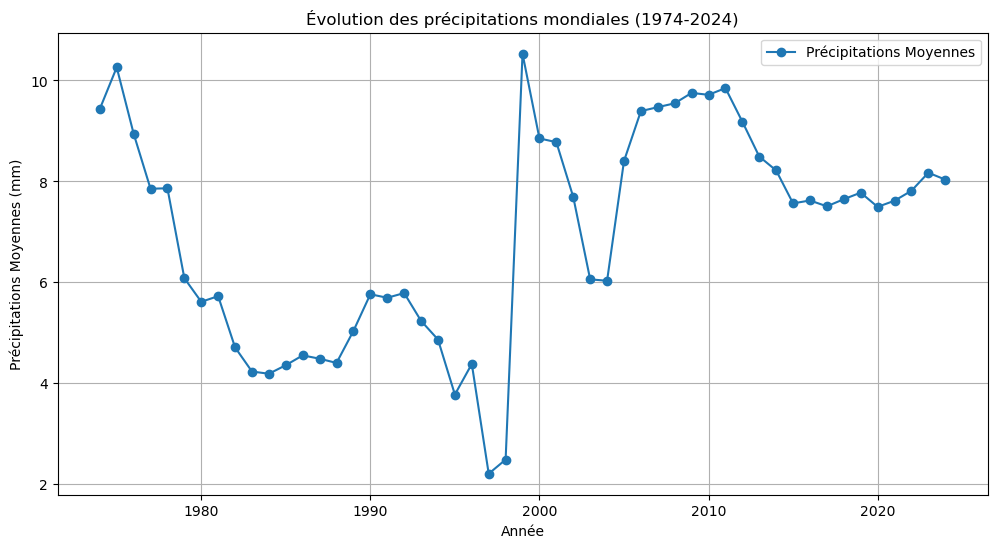


Analyse terminée avec succès.


In [15]:
def analyze_precipitation_change_optimized(data_path, start_year, end_year, cache_file="precipitation_cache.csv"):
    """
    Analyse les changements des précipitations mondiales au cours des 50 dernières années de manière optimisée.
    Utilise un fichier cache pour éviter les recalculs si les données sont déjà disponibles.
    """
    # Vérifier si les données sont déjà calculées et chargées
    if os.path.exists(cache_file):
        print(f"Chargement des données calculées à partir du cache : {cache_file}")
        return pd.read_csv(cache_file)
    
    annual_precipitation = {}

    # Charger et analyser les fichiers pour chaque année
    for year in tqdm(range(start_year, end_year + 1), desc="Traitement par année"):
        year_path = os.path.join(data_path, str(year))
        if not os.path.exists(year_path):
            print(f"Dossier manquant pour l'année {year}. Ignoré.")
            continue
        
        total_precipitation = 0
        count = 0

        # Charger tous les fichiers CSV de l'année
        for file in os.listdir(year_path):
            if file.endswith(".csv"):
                file_path = os.path.join(year_path, file)
                try:
                    # Charger en mode "chunksize" pour économiser la mémoire
                    for chunk in pd.read_csv(file_path, chunksize=10000):
                        # Filtrer les données aberrantes et manquantes
                        chunk = chunk[chunk["PRCP"] >= 0]  # Supprimer les valeurs négatives
                        chunk.dropna(subset=["PRCP"], inplace=True)

                        # Ajouter les précipitations au total annuel
                        total_precipitation += chunk["PRCP"].sum()
                        count += len(chunk)
                except Exception as e:
                    print(f"Erreur lors du chargement de {file_path}: {e}")

        # Calculer la moyenne annuelle si des données existent
        if count > 0:
            annual_precipitation[year] = total_precipitation / count
        else:
            annual_precipitation[year] = None

    # Transformer le résultat en DataFrame
    annual_precipitation_df = pd.DataFrame.from_dict(annual_precipitation, orient="index", columns=["AVG_PRCP"])
    annual_precipitation_df.index.name = "YEAR"
    annual_precipitation_df.reset_index(inplace=True)

    # Sauvegarder les résultats dans le fichier cache
    print(f"Sauvegarde des résultats dans le fichier cache : {cache_file}")
    annual_precipitation_df.to_csv(cache_file, index=False)

    # Afficher les résultats et tracer un graphique
    print("\nPrécipitations moyennes annuelles (1974-2024) :")
    print(annual_precipitation_df)

    plt.figure(figsize=(12, 6))
    plt.plot(
        annual_precipitation_df["YEAR"],
        annual_precipitation_df["AVG_PRCP"],
        marker="o",
        label="Précipitations Moyennes"
    )
    plt.title("Évolution des précipitations mondiales (1974-2024)")
    plt.xlabel("Année")
    plt.ylabel("Précipitations Moyennes (mm)")
    plt.grid(True)
    plt.legend()
    plt.show()

    return annual_precipitation_df

# Chemin des données et plage d'années
data_path = "/home/jovyan/climate_analyses/data"
start_year = 1974
end_year = 2024

# Fichier cache
cache_file = "precipitation_cache.csv"

# Analyser les précipitations mondiales de manière optimisée
precipitation_trends = analyze_precipitation_change_optimized(data_path, start_year, end_year, cache_file)

if precipitation_trends is not None:
    print("\nAnalyse terminée avec succès.")
else:
    print("\nAnalyse échouée.")


---
## Requêtes avancées


In [ ]:
# Enregistrer comme vue SQL temporaire et exécuter des requêtes
# df_transformed.createOrReplaceTempView('climate')
# spark.sql('SELECT ...')

## **Questions 5 :**
1. Quelle a été l'année la plus froide enregistrée, et quelle était la température moyenne ?
2. Quelle station a contribué avec le plus grand nombre d'enregistrements ?
3. Fournissez la requête SQL utilisée pour trouver les réponses ci-dessus.

## Réponse aux questions 5

### 1. L'année la plus froid

In [20]:
import gc

def process_year_files(year_path, year):
    """
    Traite tous les fichiers CSV d'une année donnée pour calculer la moyenne des températures.
    """
    total_temp = 0
    count_temp = 0

    # Vérifier si le dossier de l'année existe
    if not os.path.exists(year_path):
        print(f"Dossier manquant pour l'année {year}. Ignoré.")
        return None, None

    # Parcourir tous les fichiers de l'année
    for file in os.listdir(year_path):
        if file.endswith(".csv"):
            file_path = os.path.join(year_path, file)
            try:
                # Lire en mode chunksize pour réduire la mémoire utilisée
                for chunk in pd.read_csv(file_path, chunksize=10000):
                    # Supprimer les valeurs manquantes ou aberrantes
                    chunk = chunk.dropna(subset=["TEMP"])
                    total_temp += chunk["TEMP"].sum()
                    count_temp += len(chunk)
            except Exception as e:
                print(f"Erreur lors du chargement de {file_path}: {e}")

    return total_temp, count_temp


def get_coldest_year_optimized(data_path, start_year, end_year):
    """
    Identifie l'année la plus froide et sa température moyenne de manière optimisée.
    """
    year_temp_totals = {}

    for year in tqdm(range(start_year, end_year + 1), desc="Traitement par année"):
        year_path = os.path.join(data_path, str(year))
        total_temp, count_temp = process_year_files(year_path, year)

        if total_temp is not None and count_temp > 0:
            year_temp_totals[year] = total_temp / count_temp  # Calculer la moyenne pour l'année

        # Libérer explicitement la mémoire après chaque année
        gc.collect()

    if not year_temp_totals:
        print("Aucune donnée disponible pour l'analyse.")
        return None

    # Trouver l'année avec la température moyenne la plus basse
    coldest_year = min(year_temp_totals, key=year_temp_totals.get)
    coldest_temp = year_temp_totals[coldest_year]

    print(f"\nAnnée la plus froide : {coldest_year} avec une température moyenne de {coldest_temp:.2f}°C")
    return coldest_year, coldest_temp


# Chemin des données et plage d'années
data_path = "data"
start_year = 1929
end_year = 2024

# Identifier l'année la plus froide
coldest_year, coldest_temp = get_coldest_year_optimized(data_path, start_year, end_year)

if coldest_year is not None:
    print("\nAnalyse terminée avec succès.")
else:
    print("\nAnalyse échouée.")



Traitement par année: 100%|██████████| 96/96 [52:02<00:00, 32.52s/it]


Année la plus froide : 1971 avec une température moyenne de 40.03°C

Analyse terminée avec succès.


### 2. Station avec le plus grand nombre d'enregistrements de l'année la plus froide

In [23]:
def process_year_files_for_station(year_path):
    """
    Traite les fichiers CSV d'une année donnée pour compter les enregistrements par station.
    """
    station_counts = {}

    # Vérifier si le dossier de l'année existe
    if not os.path.exists(year_path):
        print(f"Dossier manquant pour l'année {year}. Ignoré.")
        return None

    # Parcourir tous les fichiers de l'année
    for file in os.listdir(year_path):
        if file.endswith(".csv"):
            file_path = os.path.join(year_path, file)
            try:
                # Lire en mode chunksize pour réduire la mémoire utilisée
                for chunk in pd.read_csv(file_path, chunksize=10000, usecols=["STATION"]):
                    # Compter les occurrences par station dans le chunk
                    station_chunk_counts = chunk["STATION"].value_counts().to_dict()

                    # Ajouter les comptes du chunk aux totaux globaux
                    for station, count in station_chunk_counts.items():
                        station_counts[station] = station_counts.get(station, 0) + count

                    # Libérer explicitement la mémoire utilisée par le chunk
                    del chunk
                    gc.collect()

            except Exception as e:
                print(f"Erreur lors du chargement de {file_path}: {e}")

    return station_counts


def get_top_station_for_coldest_year(data_path, coldest_year):
    """
    Identifie la station avec le plus grand nombre d'enregistrements pour l'année la plus froide.
    """
    year_path = os.path.join(data_path, str(coldest_year))
    station_counts = process_year_files_for_station(year_path)

    if not station_counts:
        print(f"Aucune donnée disponible pour l'année {coldest_year}.")
        return None

    # Identifier la station avec le plus grand nombre d'enregistrements
    top_station = max(station_counts, key=station_counts.get)
    top_station_count = station_counts[top_station]

    print(f"\nStation avec le plus grand nombre d'enregistrements en {coldest_year} :")
    print(f"Station ID : {top_station}, Nombre d'enregistrements : {top_station_count}")

    return top_station, top_station_count


# Chemin des données et plage d'années
data_path = "data"
start_year = 1929
end_year = 2024

# Identifier l'année la plus froide
coldest_year, coldest_temp = get_coldest_year_optimized(data_path, start_year, end_year)

if coldest_year is not None:
    # Utiliser l'année la plus froide pour trouver la station avec le plus grand nombre d'enregistrements
    top_station, top_station_count = get_top_station_for_coldest_year(data_path, coldest_year)

    print("\nAnalyse terminée avec succès.")
else:
    print("\nAnalyse échouée.")


Traitement par année: 100%|██████████| 96/96 [56:41<00:00, 35.43s/it] 



Année la plus froide : 1971 avec une température moyenne de 40.03°C

Station avec le plus grand nombre d'enregistrements en 1971 :
Station ID : 72386523112, Nombre d'enregistrements : 365

Analyse terminée avec succès.


### 3. Requetes utilisés

In [25]:
# Cas ou nos données sont stockés dans une database

# 1. Requetes SQL pour Trouver l'année la plus froide 
SELECT YEAR, AVG(TEMP) AS AVG_TEMP
FROM weather_data
WHERE TEMP IS NOT NULL
GROUP BY YEAR
ORDER BY AVG_TEMP ASC
LIMIT 1;

# 2.  Trouver la station avec le plus grand nombre d'enregistrements pour l'année la plus froide
SELECT STATION, COUNT(*) AS RECORD_COUNT
FROM weather_data
WHERE YEAR = <coldest_year>
GROUP BY STATION
ORDER BY RECORD_COUNT DESC
LIMIT 1;


SyntaxError: invalid syntax (861965273.py, line 4)

---
## Visualisation


In [ ]:
# Exporter les données vers Pandas et créer des visualisations
# import matplotlib.pyplot as plt
# df_pandas = avg_temp_by_year.toPandas()
# plt.plot(df_pandas['year'], df_pandas['avg_temperature'])

## **Questions 6 :**
1. Quelles tendances sont visibles dans le graphique des températures moyennes mondiales ?
2. Quelles anomalies sont présentes dans l'histogramme des précipitations ?
3. Quelles analyses supplémentaires recommanderiez-vous en fonction des visualisations ?

### 1. tendances sont visibles dans le graphique des températures moyennes mondiales

Traitement des fichiers pour 2020: 100%|██████████| 12298/12298 [17:49<00:00, 11.50it/s] 


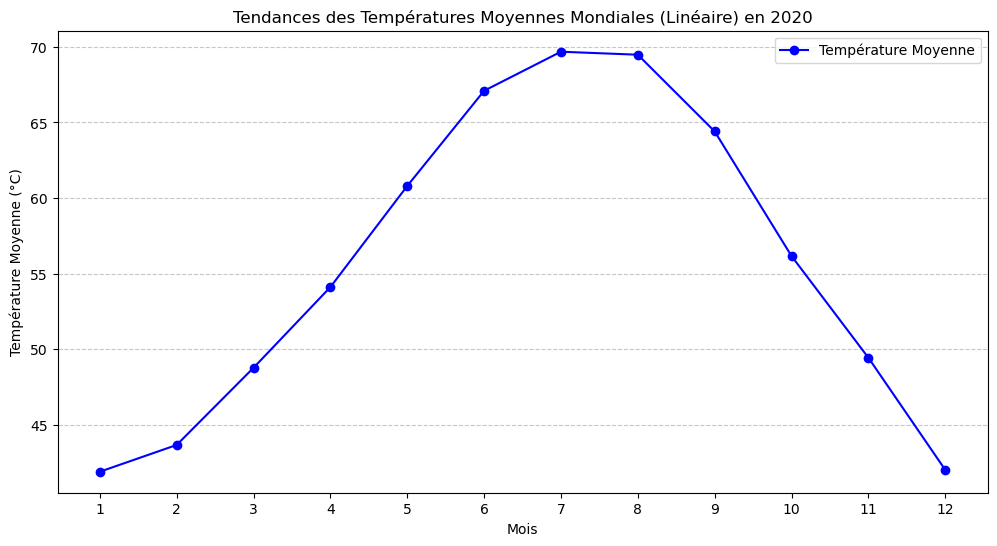

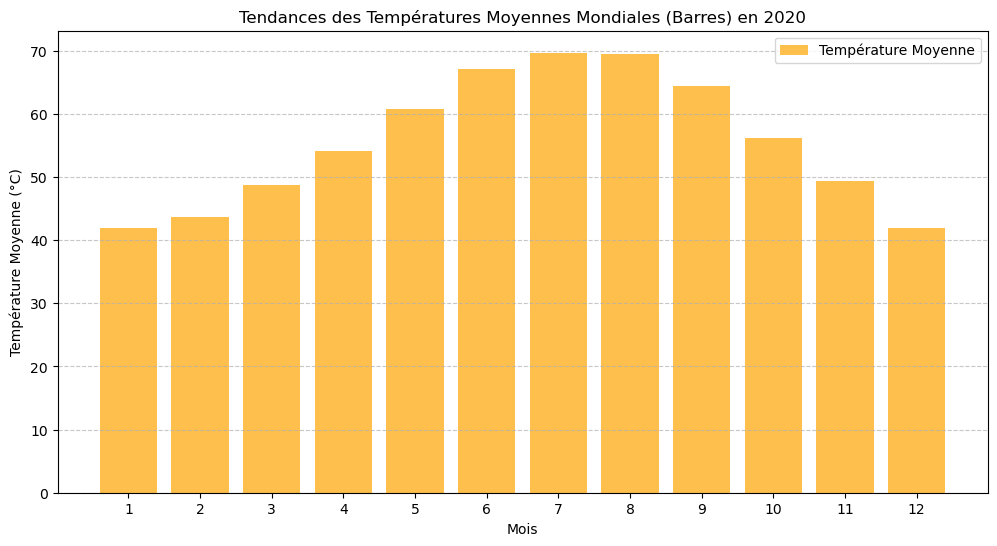

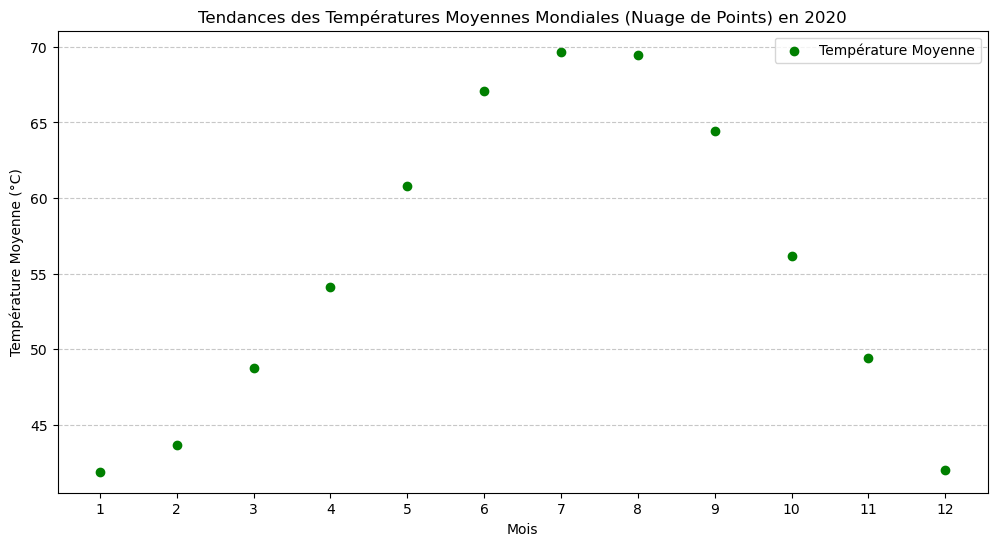

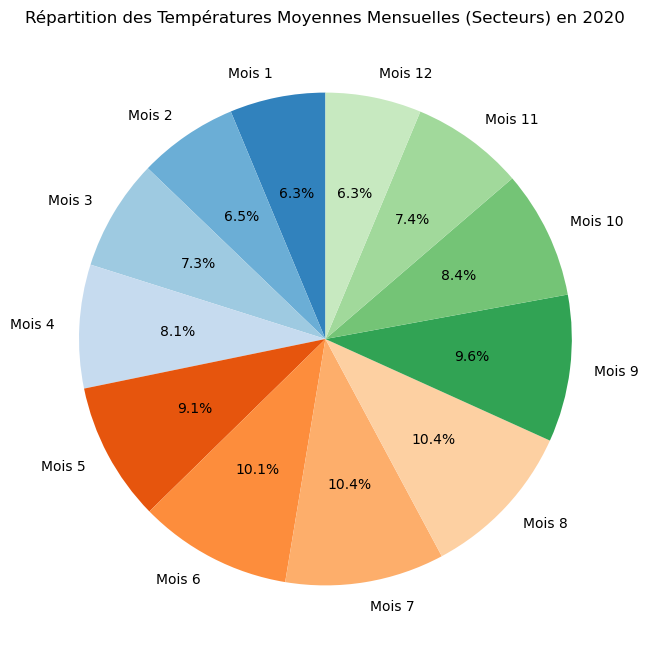


Analyse terminée avec succès.


In [26]:
from tqdm import tqdm


def process_year_for_temp_trends(data_path, year):
    """
    Traite les fichiers CSV d'une année donnée pour calculer les tendances des températures mensuelles.
    """
    monthly_temps = {month: {"total_temp": 0, "count": 0} for month in range(1, 13)}

    year_path = os.path.join(data_path, str(year))
    if not os.path.exists(year_path):
        print(f"Dossier manquant pour l'année {year}.")
        return None

    for file in tqdm(os.listdir(year_path), desc=f"Traitement des fichiers pour {year}"):
        if file.endswith(".csv"):
            file_path = os.path.join(year_path, file)
            try:
                for chunk in pd.read_csv(file_path, chunksize=10000, usecols=["DATE", "TEMP"]):
                    chunk = chunk.dropna(subset=["TEMP"])  # Supprimer les valeurs manquantes
                    chunk["MONTH"] = pd.to_datetime(chunk["DATE"]).dt.month  # Extraire le mois

                    # Ajouter les températures par mois
                    for month, group in chunk.groupby("MONTH"):
                        monthly_temps[month]["total_temp"] += group["TEMP"].sum()
                        monthly_temps[month]["count"] += len(group)

                    del chunk
                    gc.collect()

            except Exception as e:
                print(f"Erreur lors du traitement de {file_path}: {e}")

    # Calculer les moyennes mensuelles
    avg_monthly_temps = {month: (data["total_temp"] / data["count"] if data["count"] > 0 else None)
                         for month, data in monthly_temps.items()}

    return avg_monthly_temps


def plot_multiple_graphs(year, avg_monthly_temps):
    """
    Trace différents graphiques pour les tendances des températures moyennes mensuelles.
    """
    months = list(avg_monthly_temps.keys())
    temps = list(avg_monthly_temps.values())

    # Graphique Linéaire
    plt.figure(figsize=(12, 6))
    plt.plot(months, temps, marker="o", label="Température Moyenne", color="blue")
    plt.title(f"Tendances des Températures Moyennes Mondiales (Linéaire) en {year}")
    plt.xlabel("Mois")
    plt.ylabel("Température Moyenne (°C)")
    plt.xticks(months)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.legend()
    plt.show()

    # Graphique en Barres
    plt.figure(figsize=(12, 6))
    plt.bar(months, temps, color="orange", alpha=0.7, label="Température Moyenne")
    plt.title(f"Tendances des Températures Moyennes Mondiales (Barres) en {year}")
    plt.xlabel("Mois")
    plt.ylabel("Température Moyenne (°C)")
    plt.xticks(months)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.legend()
    plt.show()

    # Graphique en Nuage de Points
    plt.figure(figsize=(12, 6))
    plt.scatter(months, temps, color="green", label="Température Moyenne")
    plt.title(f"Tendances des Températures Moyennes Mondiales (Nuage de Points) en {year}")
    plt.xlabel("Mois")
    plt.ylabel("Température Moyenne (°C)")
    plt.xticks(months)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.legend()
    plt.show()

    # Graphique en Secteurs
    plt.figure(figsize=(8, 8))
    plt.pie(
        temps,
        labels=[f"Mois {month}" for month in months],
        autopct="%1.1f%%",
        startangle=90,
        colors=plt.cm.tab20c.colors[:12],
    )
    plt.title(f"Répartition des Températures Moyennes Mensuelles (Secteurs) en {year}")
    plt.show()


# Chemin des données et année à analyser
data_path = "/home/jovyan/climate_analyses/data"
year_to_analyze = 2020

# Traiter les données pour 2020
avg_monthly_temps_2020 = process_year_for_temp_trends(data_path, year_to_analyze)

if avg_monthly_temps_2020:
    # Tracer les graphiques pour les tendances des températures moyennes
    plot_multiple_graphs(year_to_analyze, avg_monthly_temps_2020)
    print("\nAnalyse terminée avec succès.")
else:
    print("\nAucune donnée disponible pour l'analyse.")


### 2. Analyse anomalies 


Années avec des sauts importants dans les précipitations :
    YEAR   AVG_PRCP      DIFF
5   1979   6.082201 -1.781249
23  1997   2.206427 -2.175942
25  1999  10.530504  8.044321
26  2000   8.851444 -1.679060
29  2003   6.058540 -1.632472
31  2005   8.402943  2.372128


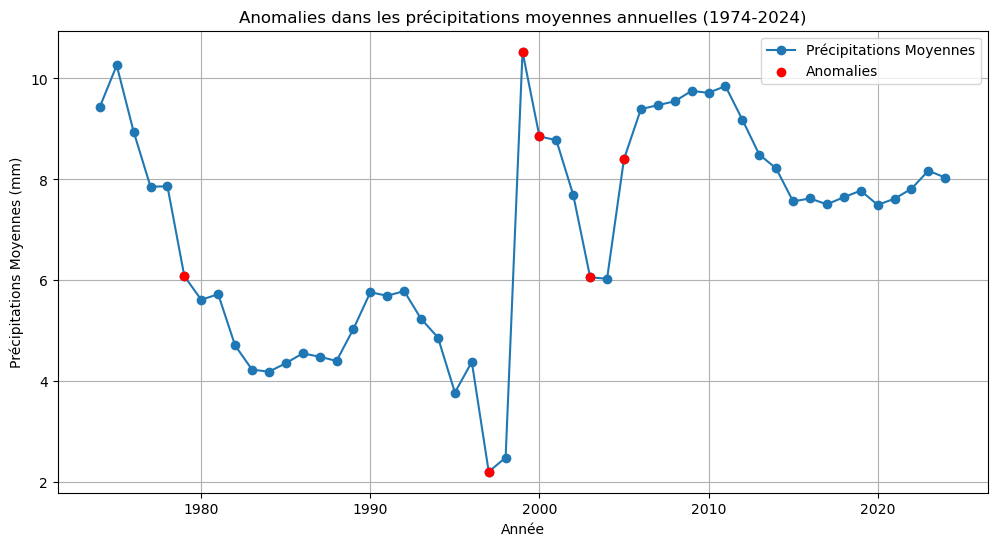

In [27]:
def analyze_anomalies(data_frame):
    """
    Analyse les anomalies dans les précipitations moyennes annuelles.
    """
    # Identification des années avec des sauts importants
    data_frame["DIFF"] = data_frame["AVG_PRCP"].diff()  # Différence entre années consécutives
    anomalies = data_frame[abs(data_frame["DIFF"]) > data_frame["DIFF"].std()]  # Seuil basé sur l'écart-type

    print("\nAnnées avec des sauts importants dans les précipitations :")
    print(anomalies[["YEAR", "AVG_PRCP", "DIFF"]])

    # Tracer les anomalies avec des points rouges
    plt.figure(figsize=(12, 6))
    plt.plot(
        data_frame["YEAR"],
        data_frame["AVG_PRCP"],
        marker="o",
        label="Précipitations Moyennes"
    )
    plt.scatter(
        anomalies["YEAR"],
        anomalies["AVG_PRCP"],
        color="red",
        label="Anomalies",
        zorder=5
    )
    plt.title("Anomalies dans les précipitations moyennes annuelles (1974-2024)")
    plt.xlabel("Année")
    plt.ylabel("Précipitations Moyennes (mm)")
    plt.grid(True)
    plt.legend()
    plt.show()

# Appeler la fonction avec les tendances des précipitations
analyze_anomalies(precipitation_trends)


---
## Optimisation et réflexion


In [ ]:
# Appliquer le cache et le repartitionnement
# df_transformed.cache()
# df_repartitioned = df_transformed.repartition(4)

**Questions :**
1. Comment la mise en cache a-t-elle amélioré les performances de vos requêtes ?
2. Comment le repartitionnement a-t-il affecté le temps d'exécution des tâches ?
3. Résumez l'information la plus surprenante que vous avez dérivée du jeu de données.